### CNN
### In this project, I have worked with convolutional neural networks for image recognition.
### Instead of individually creating each model, I created a model definition function that is adaptively configurable.
### This way, architectures could be easily modified and tuned.

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as tk
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import Adam,Nadam,RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback

In [3]:
# Load Cifar-10 Data
(x_train, y_train), (x_test, y_test) = tk.datasets.cifar10.load_data()
print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

170498071/170498071 [==============================] - 6s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


In [4]:
#One-Hot encoding labels
def to_one_hot(y,num_class=10):
    hot=np.zeros((y.shape[0],num_class))
    hot[np.arange(y.shape[0]),y.flatten()]=1
    return hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)
print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))
print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [5]:
x_tr,x_val,y_tr,y_val=train_test_split(x_train,y_train_vec,test_size=10000,random_state=42)
print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


In [1]:
# I have created a function to take in a configuration in list form,
# and define a model matching this architecture.
# This function will then train the model and return the highest validation accuracy.
# Here are the adjustable parameters:
# 
# Optimizer, Learning Rate, Batch Size, padding(yes/no)
# Data Augmentation terms
# And an adaptive layer depth with customizable type, size, batch norm, dropout, and activation
#
# With this we can easily search through a variety of configurations and find the best fit.

In [18]:
def CustCNN(i,epochs,x_train,y_train,x_val,y_val,optimizer,learning_rate,batch_size,padding,data_gen_params,*layer_params):
    #Data Augmentation
    datagen = ImageDataGenerator(**data_gen_params)
    #Only augment train data
    train_generator = datagen.flow(x_tr, y_tr, batch_size=batch_size)
    #First conv/dense indicator for input
    firstC=True
    firstD=True
    #Create the CNN model based on the provided parameters
    model = Sequential()
    #Iterate through each individual layers configuration
    for param in layer_params:
        #Convolutional Layers:
        if param[0] == 'conv':
            #If first layer add input dim.
            if(firstC):
                model.add(Conv2D(*param[1],padding=padding,input_shape=(32, 32, 3)))
                firstC=False
            #Generally append conv2d layer w/ no padding and desired filters
            else:
                model.add(Conv2D(*param[1],padding=padding))
            #Batch Normalization
            if param[2]:
                model.add(BatchNormalization())
            #Dropout
            if param[3] is not None:
                model.add(Dropout(param[3]))
            #Activation
            model.add(Activation(param[4]))
            #Max Pool
            if param[5] is not None:
                model.add(MaxPooling2D(*param[5]))
        #Dense Layers:
        elif param[0] == 'dense':
            #Flatten if first Dense Layer
            if(firstD):
                model.add(Flatten())
                firstD=False
            #Add Dense Layer
            model.add(Dense(*param[1]))
            #Batch Normalization
            if param[2]:
                model.add(BatchNormalization())
            #Dropout
            if param[3] is not None:
                model.add(Dropout(param[3]))
            #Activation
            model.add(Activation(param[4]))
    #Output Layer
    model.add(Dense(10, activation='softmax'))
    model.summary()
    #Compile the model with desired lr, loss, and optim
    optim=optimizer(learning_rate=learning_rate)
    loss='categorical_crossentropy'
    model.compile(loss=loss,optimizer=optim,metrics=['acc'])
    #Train the model
    m = model.fit(train_generator,epochs=epochs,validation_data=(x_val,y_val),verbose=0,callbacks=[TqdmCallback(verbose=0)])
    #Extract Performance
    train_loss=m.history['loss']
    val_loss=m.history['val_loss']
    train_acc=m.history['acc']
    val_acc=m.history['val_acc']
    #Print Last Epochs Score
    print(f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}')
    print(f'Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}')
    #Return lowest validation accuracy reached at any epoch
    return max(val_acc),train_loss,val_loss,train_acc,val_acc

# Finding Best Model:

In [19]:
# Baseline
config1=[RMSprop,.0001,32,'valid',#Optimizer,learning,rate,batch_size,padding
         #Data Augmentation Parameters 
         {'rotation_range':0,'width_shift_range':0,'height_shift_range':0,'zoom_range':0,
          'horizontal_flip': False,'vertical_flip': False,'fill_mode': 'nearest','rescale':0},
         #Layer_Type,(Filters(Filter_Size)),BatchNorm,DropoutProb,Activation,MaxPoolSize
         ('conv',(32,(3,3)),False,None,'relu',(2,2)),
         ('conv',(64,(4,4)),False,None,'relu',(2,2)),
         ('dense',(256,),False,None, 'relu')]
#Second adds dropout & batch norm on all layers:
config2=[RMSprop,.0001,32,'valid',
         {'rotation_range':0,'width_shift_range':0,'height_shift_range':0,'zoom_range':0,
          'horizontal_flip': False,'vertical_flip': False,'fill_mode': 'nearest','rescale':0},
         ('conv',(32,(3,3)),True,.1,'relu',(2,2)),
         ('conv',(64,(4,4)),True,.1,'relu',(2,2)),
         ('dense',(256,),True,.5, 'relu')]
#Third adds data augmentation:
config3=[RMSprop,.0001,32,'valid',
         {'rotation_range':10,'width_shift_range':.1,'height_shift_range':.1,'zoom_range':0,
          'horizontal_flip': True,'vertical_flip': False,'fill_mode':'nearest','rescale':0},
         ('conv',(32,(3,3)),True,.1,'relu',(2,2)),
         ('conv',(64,(4,4)),True,.1,'relu',(2,2)),
         ('dense',(256,),True,.5, 'relu')]
#Fourth Attempts to mimic VGG16:
config4 = [Adam, 0.001, 64,'same',
        {'rotation_range': 15, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1,
         'horizontal_flip': True, 'vertical_flip': False, 'fill_mode': 'nearest', 'rescale': 0},
        ('conv', (64, (3, 3)), True, None, 'relu', None),
        ('conv', (64, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (128, (3, 3)), True, None, 'relu', None),
        ('conv', (128, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (256, (3, 3)), True, None, 'relu', None),
        ('conv', (256, (3, 3)), True, None, 'relu', None),
        ('conv', (256, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (512, (3, 3)), True, None, 'relu', None),
        ('conv', (512, (3, 3)), True, None, 'relu', None),
        ('conv', (512, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (512, (3, 3)), True, None, 'relu', None),
        ('conv', (512, (3, 3)), True, None, 'relu', None),
        ('conv', (512, (3, 3)), True, None, 'relu', (2, 2)),
        ('dense', (4096,), True, 0.5, 'relu'),
        ('dense', (4096,), True, 0.5, 'relu'),]
#Fifth & Sixth follows: https://www.researchgate.net/figure/Well-tuned-CNN-architecture-for-CIFAR-10-dataset-Left-This-network-is-generated-by_fig3_326816043
config5=[RMSprop,.0001,32,'same',
         {'rotation_range':10,'width_shift_range':.1,'height_shift_range':.1,'zoom_range':0,
          'horizontal_flip': True,'vertical_flip': False,'fill_mode':'nearest','rescale':0},
         ('conv',(96,(5,5)),True,None,'relu',(2,2)),
         ('conv',(80,(5,5)),True,None,'relu',(2,2)),
         ('conv',(96,(5,5)),True,None,'relu',None),
         ('conv',(64,(5,5)),True,None,'relu',None),
         ('dense',(256,),False,.4,'relu')]
config6=[RMSprop,.0001,32,'same',
         {'rotation_range':10,'width_shift_range':.1,'height_shift_range':.1,'zoom_range':0,
          'horizontal_flip': True,'vertical_flip': False,'fill_mode':'nearest','rescale':0},
         ('conv',(96,(5,5)),True,None,'relu',(2,2)),
         ('conv',(96,(5,5)),True,None,'relu',(2,2)),
         ('conv',(80,(5,5)),True,None,'relu',None),
         ('conv',(64,(5,5)),True,None,'relu',None),
         ('conv',(64,(5,5)),True,None,'relu',None),
         ('conv',(96,(5,5)),True,None,'relu',None),
         ('dense',(256,),False,.4,'relu')]
#Remaining models are a random mix
config7 = [Adam, 0.001, 64,'valid',
        {'rotation_range': 15, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1,
        'horizontal_flip': True, 'vertical_flip': False, 'fill_mode': 'nearest', 'rescale': 0},
        ('conv', (32, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (64, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (128, (3, 3)), True, None, 'relu', (2, 2)),
        ('dense', (512,), True, 0.5, 'relu')]
config8 = [SGD, 0.01, 128,'same',
        {'rotation_range': 20, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'zoom_range': 0.2,
        'horizontal_flip': True, 'vertical_flip': True, 'fill_mode': 'reflect', 'rescale': 0},
        ('conv', (16, (3, 3)), False, None, 'relu', (2, 2)),
        ('conv', (32, (3, 3)), False, None, 'relu', (2, 2)),
        ('conv', (64, (3, 3)), False, None, 'relu', (2, 2)),
        ('conv', (128, (3, 3)), False, None, 'relu', (2, 2)),
        ('dense', (256,), True, 0.5, 'relu')]
config9 = [Nadam, 0.0005, 32,'same',
        {'rotation_range': 10, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1,
        'horizontal_flip': True, 'vertical_flip': False, 'fill_mode': 'nearest', 'rescale': 0},
        ('conv', (64, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (128, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (256, (3, 3)), True, None, 'relu', (2, 2)),
        ('conv', (512, (3, 3)), True, None, 'relu', (2, 2)),
        ('dense', (1024,), True, 0.5, 'relu')]
configs=[config1,config2,config3,config4,config5,config6,config7,config8,config9]
#standard of 50 epochs
epochs=50
best_val_acc=0
best_config=-1
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for i,config in enumerate(configs):
    optimizer=config[0]
    learning_rate=config[1]
    batch_size=config[2]
    padding=config[3]
    data_gen_params=config[4]
    layer_params = config[5:]
    print('Config '+str(i+1)+':')
    max_val_acc,train_loss,val_loss,train_acc,val_acc=CustCNN(i,epochs,x_tr,y_tr,x_val,y_val,optimizer,learning_rate,batch_size,padding,data_gen_params,*layer_params)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    if(max_val_acc>best_val_acc):
        best_val_acc=max_val_acc
        best_config=i
print('Best is config'+str(best_config+1)+' with validation accuracy of '+str(round(best_val_acc*100,4))+'%')
print(configs[best_config])

Config 1:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_7 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                        

0epoch [00:00, ?epoch/s]

Train Loss: 0.0713, Train Accuracy: 0.9796
Validation Loss: 3.8702, Validation Accuracy: 0.6537
Config 2:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.4416, Train Accuracy: 0.8541
Validation Loss: 0.9818, Validation Accuracy: 0.7122
Config 3:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 activation_12 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.8622, Train Accuracy: 0.7084
Validation Loss: 0.9990, Validation Accuracy: 0.6868
Config 4:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.5118, Train Accuracy: 0.8319
Validation Loss: 0.6804, Validation Accuracy: 0.7828
Config 5:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 96)        7296      
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 80)        192080    
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.5177, Train Accuracy: 0.8308
Validation Loss: 1.5383, Validation Accuracy: 0.7603
Config 6:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 96)        7296      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 96)        230496    
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.4990, Train Accuracy: 0.8424
Validation Loss: 0.9465, Validation Accuracy: 0.7957
Config 7:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_31 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 13, 13, 64)        18496     
              

0epoch [00:00, ?epoch/s]

Train Loss: 0.5121, Train Accuracy: 0.8221
Validation Loss: 0.5794, Validation Accuracy: 0.8076
Config 8:
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 activation_46 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 activation_47 (Activation)  (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d

0epoch [00:00, ?epoch/s]

Train Loss: 1.2793, Train Accuracy: 0.5414
Validation Loss: 1.0475, Validation Accuracy: 0.6254
Config 9:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_36 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_51 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 128)       73856     
             

0epoch [00:00, ?epoch/s]

Train Loss: 0.1718, Train Accuracy: 0.9408
Validation Loss: 0.5331, Validation Accuracy: 0.8615
Best is config9 with validation accuracy of 86.96%
[<class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 0.0005, 32, 'same', {'rotation_range': 10, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1, 'horizontal_flip': True, 'vertical_flip': False, 'fill_mode': 'nearest', 'rescale': 0}, ('conv', (64, (3, 3)), True, None, 'relu', (2, 2)), ('conv', (128, (3, 3)), True, None, 'relu', (2, 2)), ('conv', (256, (3, 3)), True, None, 'relu', (2, 2)), ('conv', (512, (3, 3)), True, None, 'relu', (2, 2)), ('dense', (1024,), True, 0.5, 'relu')]


# Visualizing Training Curves vs model

Config 1: Identical structure to assigned, no tricks, serves as baseline
Best Metrics:
Best Train Loss: 0.0628, Best Train Accuracy: 0.9809
Best Validation Loss: 1.1518, Best Validation Accuracy: 0.6637
Final Metrics:
Final Train Loss: 0.0713, Final Train Accuracy: 0.9796
Final Validation Loss: 3.8702, Final Validation Accuracy: 0.6537


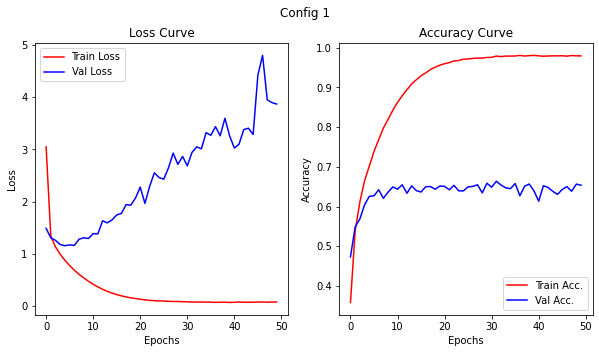

Config 2: Adds dropout & batch normalization to previous model
Best Metrics:
Best Train Loss: 0.4353, Best Train Accuracy: 0.8565
Best Validation Loss: 0.8574, Best Validation Accuracy: 0.7275
Final Metrics:
Final Train Loss: 0.4416, Final Train Accuracy: 0.8541
Final Validation Loss: 0.9818, Final Validation Accuracy: 0.7122


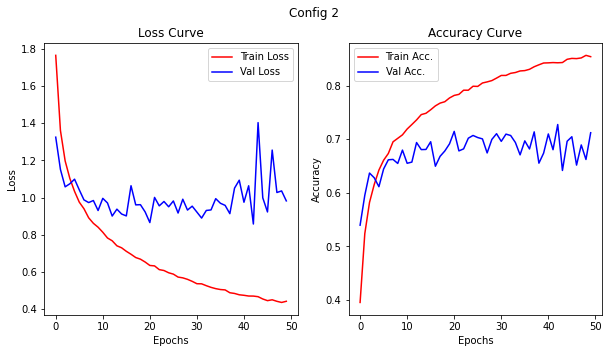

Config 3: Adds data augmentation to previous model
Best Metrics:
Best Train Loss: 0.8540, Best Train Accuracy: 0.7154
Best Validation Loss: 0.7722, Best Validation Accuracy: 0.7468
Final Metrics:
Final Train Loss: 0.8622, Final Train Accuracy: 0.7084
Final Validation Loss: 0.9990, Final Validation Accuracy: 0.6868


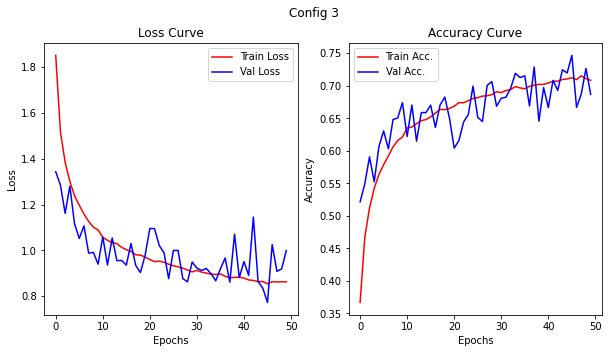

Config 4: Attempts to mimic VGG16
Best Metrics:
Best Train Loss: 0.5118, Best Train Accuracy: 0.8319
Best Validation Loss: 0.5594, Best Validation Accuracy: 0.8098
Final Metrics:
Final Train Loss: 0.5118, Final Train Accuracy: 0.8319
Final Validation Loss: 0.6804, Final Validation Accuracy: 0.7828


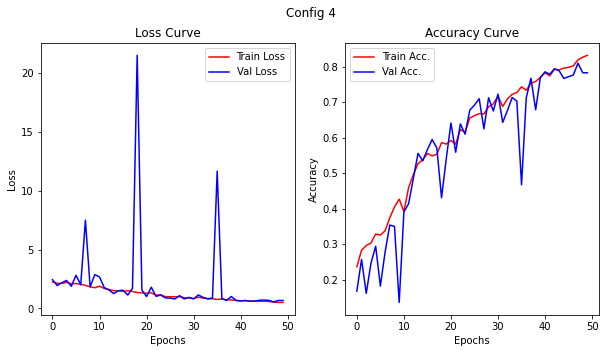

Config 5: From research, similar to assigned architecture
Best Metrics:
Best Train Loss: 0.5177, Best Train Accuracy: 0.8314
Best Validation Loss: 0.6494, Best Validation Accuracy: 0.8110
Final Metrics:
Final Train Loss: 0.5177, Final Train Accuracy: 0.8308
Final Validation Loss: 1.5383, Final Validation Accuracy: 0.7603


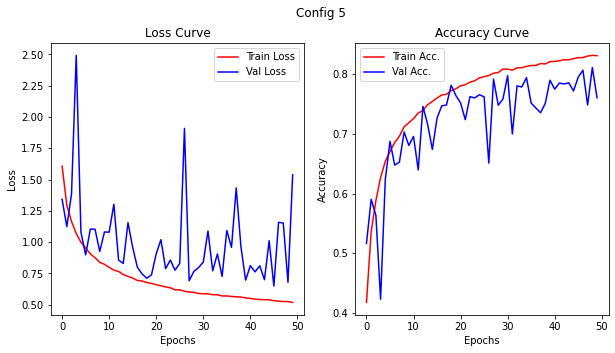

Config 6: From research, deeper than assigned architecture
Best Metrics:
Best Train Loss: 0.4990, Best Train Accuracy: 0.8429
Best Validation Loss: 0.6912, Best Validation Accuracy: 0.8030
Final Metrics:
Final Train Loss: 0.4990, Final Train Accuracy: 0.8424
Final Validation Loss: 0.9465, Final Validation Accuracy: 0.7957


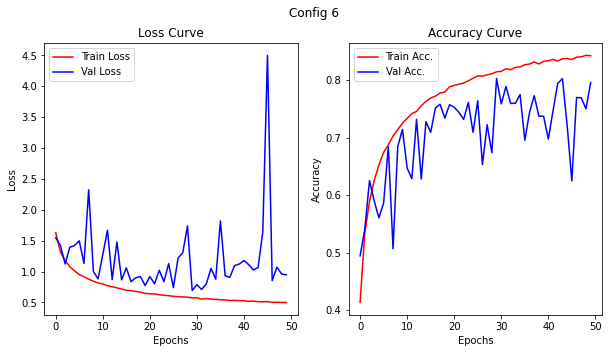

Config 7: Randomly constructed architecture
Best Metrics:
Best Train Loss: 0.5097, Best Train Accuracy: 0.8221
Best Validation Loss: 0.5061, Best Validation Accuracy: 0.8268
Final Metrics:
Final Train Loss: 0.5121, Final Train Accuracy: 0.8221
Final Validation Loss: 0.5794, Final Validation Accuracy: 0.8076


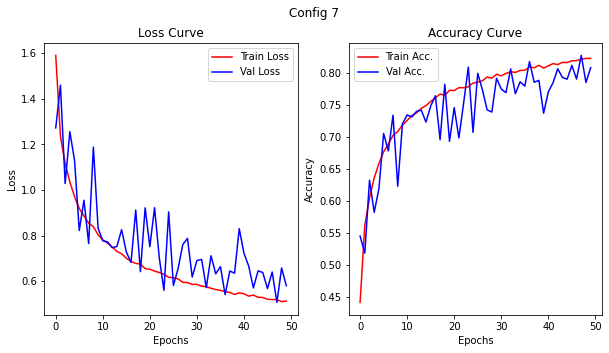

Config 8: Randomly constructed architecture
Best Metrics:
Best Train Loss: 1.2793, Best Train Accuracy: 0.5414
Best Validation Loss: 1.0475, Best Validation Accuracy: 0.6254
Final Metrics:
Final Train Loss: 1.2793, Final Train Accuracy: 0.5414
Final Validation Loss: 1.0475, Final Validation Accuracy: 0.6254


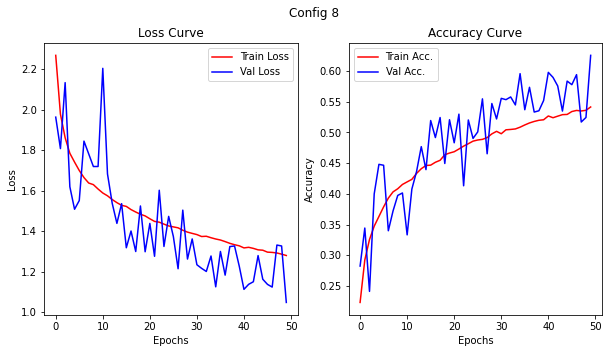

Config 9: Randomly constructed architecture
Best Metrics:
Best Train Loss: 0.1718, Best Train Accuracy: 0.9408
Best Validation Loss: 0.4569, Best Validation Accuracy: 0.8696
Final Metrics:
Final Train Loss: 0.1718, Final Train Accuracy: 0.9408
Final Validation Loss: 0.5331, Final Validation Accuracy: 0.8615


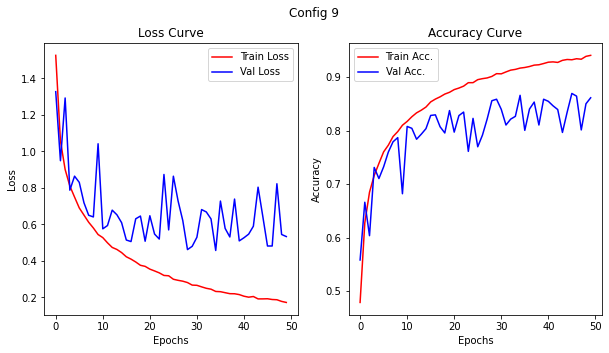

In [31]:
descs=['Baseline',
       'Adds dropout & batch normalization to previous model',
       'Adds data augmentation to previous model',
       'Attempts to mimic VGG16',
       'From research, similar to assigned architecture',
       'From research, deeper than assigned architecture',
       'Randomly constructed architecture',
       'Randomly constructed architecture',
       'Randomly constructed architecture']
for i in range(len(descs)):
    tl=train_losses[i]
    vl=val_losses[i]
    ta=train_accs[i]
    va=val_accs[i]
    print('Config '+str(i+1)+': '+descs[i])
    print('Best Metrics:')
    print(f'Best Train Loss: {min(tl):.4f}, Best Train Accuracy: {max(ta):.4f}')
    print(f'Best Validation Loss: {min(vl):.4f}, Best Validation Accuracy: {max(va):.4f}')
    print('Final Metrics:')
    print(f'Final Train Loss: {tl[-1]:.4f}, Final Train Accuracy: {ta[-1]:.4f}')
    print(f'Final Validation Loss: {vl[-1]:.4f}, Final Validation Accuracy: {va[-1]:.4f}')
    #Plot Loss & Accuracy Graphs
    epochs=range(len(tl))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(epochs,tl,'r',label='Train Loss')
    axs[0].plot(epochs,vl,'b',label='Val Loss')
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(epochs,ta,'r',label='Train Acc.')
    axs[1].plot(epochs,va,'b',label='Val Acc.')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.suptitle('Config '+str(i+1))
    plt.show()

# Retraining best config on full data

In [24]:
#Not ideal to rewrite this func. now, should have been done earlier
#But im not retraining 9 models
def buildModel(padding,*layer_params):
    #First conv/dense indicator for input
    firstC=True
    firstD=True
    #Create the CNN model based on the provided parameters
    model = Sequential()
    #Iterate through each individual layers configuration
    for param in layer_params:
        #Convolutional Layers:
        if param[0] == 'conv':
            #If first layer add input dim.
            if(firstC):
                model.add(Conv2D(*param[1],padding=padding,input_shape=(32, 32, 3)))
                firstC=False
            #Generally append conv2d layer w/ no padding and desired filters
            else:
                model.add(Conv2D(*param[1],padding=padding))
            #Batch Normalization
            if param[2]:
                model.add(BatchNormalization())
            #Dropout
            if param[3] is not None:
                model.add(Dropout(param[3]))
            #Activation
            model.add(Activation(param[4]))
            #Max Pool
            if param[5] is not None:
                model.add(MaxPooling2D(*param[5]))
        #Dense Layers:
        elif param[0] == 'dense':
            #Flatten if first Dense Layer
            if(firstD):
                model.add(Flatten())
                firstD=False
            #Add Dense Layer
            model.add(Dense(*param[1]))
            #Batch Normalization
            if param[2]:
                model.add(BatchNormalization())
            #Dropout
            if param[3] is not None:
                model.add(Dropout(param[3]))
            #Activation
            model.add(Activation(param[4]))
    #Output Layer
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

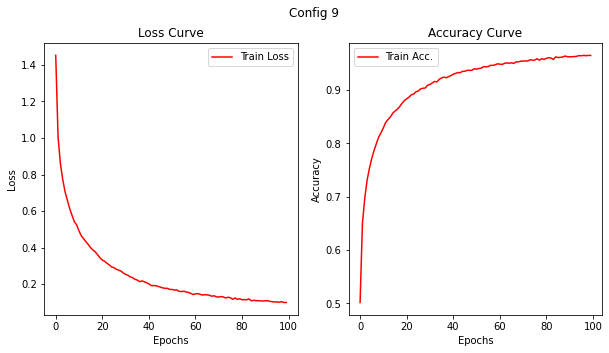

313/313 [==============================] - 1s 2ms/step - loss: 0.5490 - acc: 0.8734

Testing Accuracy: 87.34%
Testing Loss: 0.549


In [33]:
#Full training the very best config
config=configs[best_config]
optimizer=config[0]
learning_rate=config[1]
batch_size=config[2]
padding=config[3]
data_gen_params=config[4]
layer_params = config[5:]
datagen = ImageDataGenerator(**data_gen_params)
train_generator = datagen.flow(x_train, y_train_vec, batch_size=batch_size)#Full Data
optim=optimizer(learning_rate=learning_rate)
loss='categorical_crossentropy'
model=buildModel(padding,*layer_params)
model.compile(loss=loss,optimizer=optim,metrics=['acc'])
#Train the model
mb = model.fit(train_generator,batch_size=batch_size,epochs=100,verbose=0,callbacks=[TqdmCallback(verbose=0)])
#Extract Performance
tl=mb.history['loss']
ta=mb.history['acc']
#Print and plot performance
print('Best Metrics:')
print(f'Best Train Loss: {min(tl):.4f}, Best Train Accuracy: {max(ta):.4f}')
print('Final Metrics:')
print(f'Final Train Loss: {tl[-1]:.4f}, Final Train Accuracy: {ta[-1]:.4f}')
epochs=range(len(tl))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(epochs,tl,'r',label='Train Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs,ta,'r',label='Train Acc.')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('Config '+str(i+1))
plt.show()
#Evaluate model on test set
res=model.evaluate(x_test,y_test_vec)
print()
print('Testing Accuracy: '+str(round(res[1]*100,4))+'%')
print('Testing Loss: '+str(round(res[0],5)))

# Also testing VGG16 imitation

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_51 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_66 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_52 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_67 (Activation)  (None, 32, 32, 64)      

0epoch [00:00, ?epoch/s]

Best Metrics:
Best Train Loss: 0.0903, Best Train Accuracy: 0.9698
Final Metrics:
Final Train Loss: 0.0903, Final Train Accuracy: 0.9698


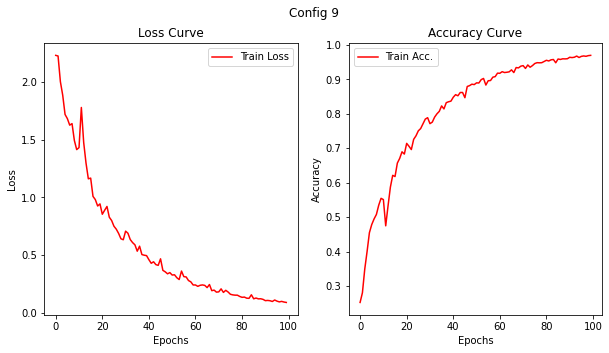

313/313 [==============================] - 1s 3ms/step - loss: 0.4707 - acc: 0.8861

Testing Accuracy: 88.61%
Testing Loss: 0.47072


In [34]:
#Full training the very best config
config=configs[3]
optimizer=config[0]
learning_rate=config[1]
batch_size=config[2]
padding=config[3]
data_gen_params=config[4]
layer_params = config[5:]
datagen = ImageDataGenerator(**data_gen_params)
train_generator = datagen.flow(x_train, y_train_vec, batch_size=batch_size)#Full Data
optim=optimizer(learning_rate=learning_rate)
loss='categorical_crossentropy'
model=buildModel(padding,*layer_params)
model.compile(loss=loss,optimizer=optim,metrics=['acc'])
#Train the model
mv = model.fit(train_generator,batch_size=batch_size,epochs=100,verbose=0,callbacks=[TqdmCallback(verbose=0)])
#Extract Performance
tl=mv.history['loss']
ta=mv.history['acc']
#Print and plot performance
print('Best Metrics:')
print(f'Best Train Loss: {min(tl):.4f}, Best Train Accuracy: {max(ta):.4f}')
print('Final Metrics:')
print(f'Final Train Loss: {tl[-1]:.4f}, Final Train Accuracy: {ta[-1]:.4f}')
epochs=range(len(tl))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(epochs,tl,'r',label='Train Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs,ta,'r',label='Train Acc.')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('Config '+str(i+1))
plt.show()
#Evaluate model on test set
res=model.evaluate(x_test,y_test_vec)
print()
print('Testing Accuracy: '+str(round(res[1]*100,4))+'%')
print('Testing Loss: '+str(round(res[0],5)))

# 88.61% Accuracy Reached !